<a href="https://colab.research.google.com/github/HiteshAI/Projects/blob/master/vehicle_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Download data from kaggle to gdrive and make it ready for submission to kaggle directly**

In [0]:
#import necessary libraries
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
import pandas as pd
from fastai.metrics import error_rate
from fastai.callbacks import *
from PIL import ImageFile
from pathlib import Path
ImageFile.LOAD_TRUNCATED_IMAGES = True
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [1]:
!nvidia-smi

Mon Nov 11 09:06:49 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
#This will prompt you for authentication from gdrive. Click the link and allow colab to access your drive folders
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

#Path to your gdrive data directory
path= '/content/drive/My Drive/vehicle_classification'
path = Path(path)
data_path = path/'vehicle_classification_dataset'
model_path= path/'models'

In [0]:
def get_data(bs, sz):
  tfms = get_transforms()
  data = (ImageList.
                  from_folder(f'{data_path}').
                  filter_by_folder(include=['train']).
                  # use_partial_data(sample_pct=0.3). #take on 10% of available input data for faster evaluation
                  split_by_rand_pct(valid_pct = 0.25, seed=42). #set train/valid split to 80:20
                  label_from_folder().
                  add_test_folder().
                  transform(tfms,size=sz).
                  databunch(bs=bs, num_workers=0)   
               )
  data.normalize(imagenet_stats)
  return data

def do_fit(bs,sz,epochs,lr, freeze=True):
    learn.dbunch = get_data(bs, sz)
    if freeze:
        learn.freeze()
        learn.fit_one_cycle(10, slice(lr))
    learn.unfreeze()
    learn.fit_one_cycle(epochs, slice(lr))

def classification_interp(learn):
  data = learn.data
  interp = ClassificationInterpretation.from_learner(learn)
  losses,idxs = interp.top_losses()
  len(data.valid_ds)==len(losses)==len(idxs)
  interp.plot_top_losses(9, figsize=(15,11))
  interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
  interp.most_confused(min_val=2)


In [0]:
# from google.colab import files
# files.upload()  #this will prompt you to upload the kaggle.json

In [0]:
# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !ls ~/.kaggle
# !chmod 600 /root/.kaggle/kaggle.json  # set permission

In [0]:
# path= '/content/drive/My Drive/vehicle_classification'
# path = Path(path)
# data_path = path/'vehicle_classification_dataset'
# model_path= path/'models'
# # !kaggle competitions download -c understanding_cloud_organization -p /content/drive/My\ Drive/cloud_formation/cloud_formation_dataset
# # !kaggle competitions download vehicle -p /content/drive/My\ Drive/vehicle_classification/vehicle_classification_dataset -o

In [0]:
# !unzip -q -n /content/drive/My\ Drive/vehicle_classification/vehicle_classification_dataset/vehicle.zip -d /content/drive/My\ Drive/vehicle_classification/vehicle_classification_dataset

In [0]:
# !unzip -q -n /content/drive/My\ Drive/vehicle_classification/vehicle_classification_dataset/train.zip -d /content/drive/My\ Drive/vehicle_classification/vehicle_classification_dataset/train

In [0]:
# !unzip -q -n /content/drive/My\ Drive/vehicle_classification/vehicle_classification_dataset/test.zip -d /content/drive/My\ Drive/vehicle_classification/vehicle_classification_dataset/test

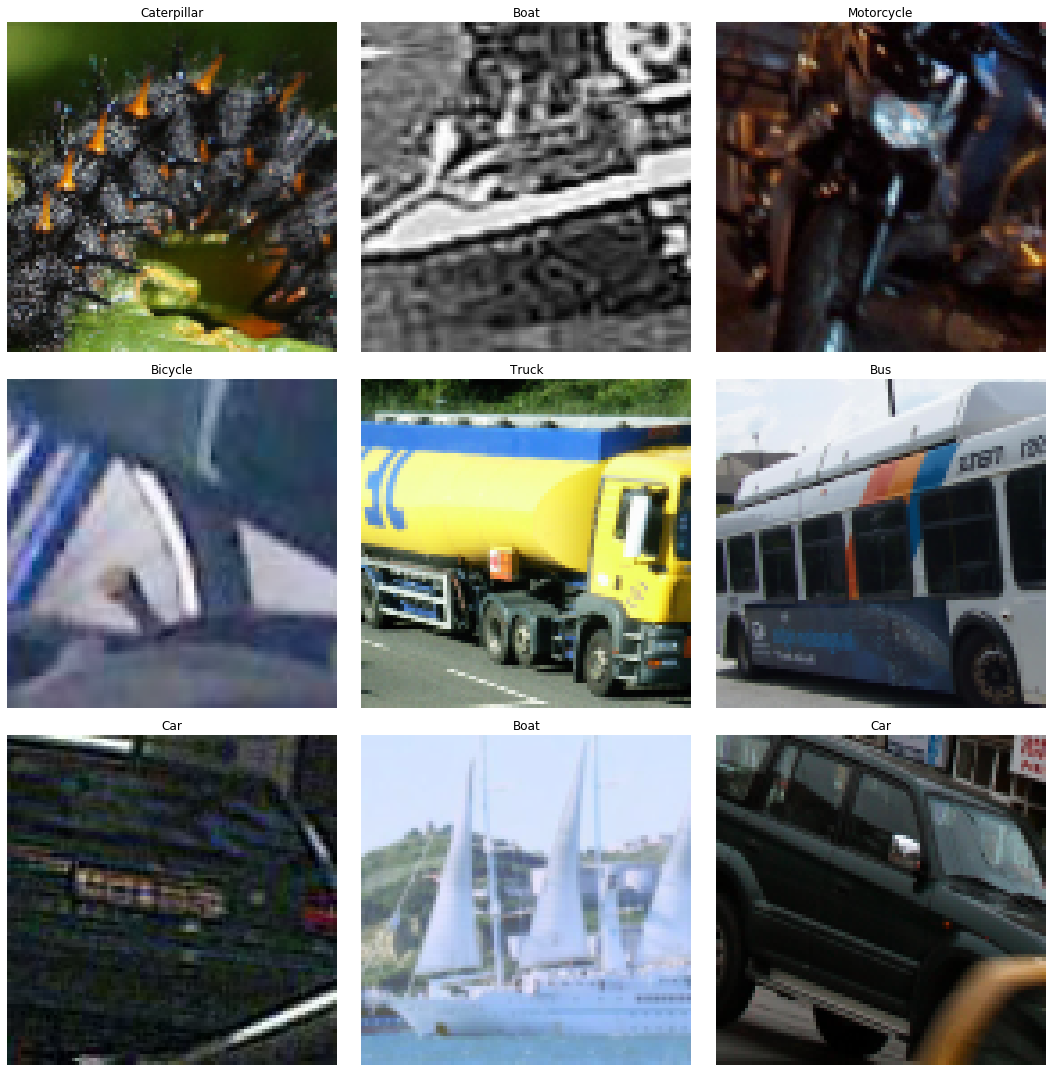

In [8]:
data = get_data(92, 92)
data
data.show_batch(rows=3, figsize=(10,10))  

In [9]:
learn = cnn_learner(data, models.resnet18 , pretrained=True, model_dir= model_path , metrics=[error_rate, accuracy], callback_fns=[partial(EarlyStoppingCallback, monitor='accuracy', min_delta=0.01, patience=3)])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 46.0MB/s]


In [0]:
learn.freeze()

In [11]:
learn.data

ImageDataBunch;

Train: LabelList (21034 items)
x: ImageList
Image (3, 92, 92),Image (3, 92, 92),Image (3, 92, 92),Image (3, 92, 92),Image (3, 92, 92)
y: CategoryList
Ambulance,Ambulance,Ambulance,Ambulance,Ambulance
Path: /content/drive/My Drive/vehicle_classification/vehicle_classification_dataset;

Valid: LabelList (7011 items)
x: ImageList
Image (3, 92, 92),Image (3, 92, 92),Image (3, 92, 92),Image (3, 92, 92),Image (3, 92, 92)
y: CategoryList
Boat,Truck,Caterpillar,Helicopter,Motorcycle
Path: /content/drive/My Drive/vehicle_classification/vehicle_classification_dataset;

Test: LabelList (7958 items)
x: ImageList
Image (3, 92, 92),Image (3, 92, 92),Image (3, 92, 92),Image (3, 92, 92),Image (3, 92, 92)
y: EmptyLabelList
,,,,
Path: /content/drive/My Drive/vehicle_classification/vehicle_classification_dataset

In [12]:
learn.fit_one_cycle(6, 1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,time


KeyboardInterrupt: ignored

In [0]:
do_fit(128, 128, 10, 1e-3)

[('Truck', 'Car', 14),
 ('Barge', 'Boat', 7),
 ('Car', 'Boat', 7),
 ('Car', 'Truck', 7),
 ('Van', 'Car', 7),
 ('Taxi', 'Car', 6),
 ('Boat', 'Car', 5),
 ('Truck', 'Van', 5),
 ('Motorcycle', 'Bicycle', 4),
 ('Van', 'Truck', 4),
 ('Bus', 'Truck', 3),
 ('Helicopter', 'Boat', 3),
 ('Bicycle', 'Motorcycle', 2),
 ('Boat', 'Bicycle', 2),
 ('Boat', 'Bus', 2),
 ('Bus', 'Car', 2),
 ('Motorcycle', 'Car', 2),
 ('Truck', 'Boat', 2),
 ('Van', 'Ambulance', 2)]

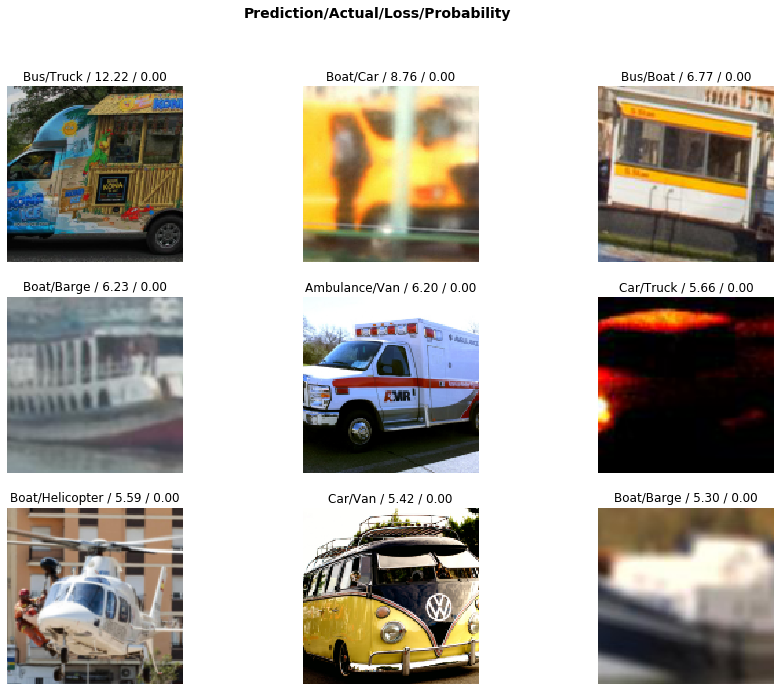

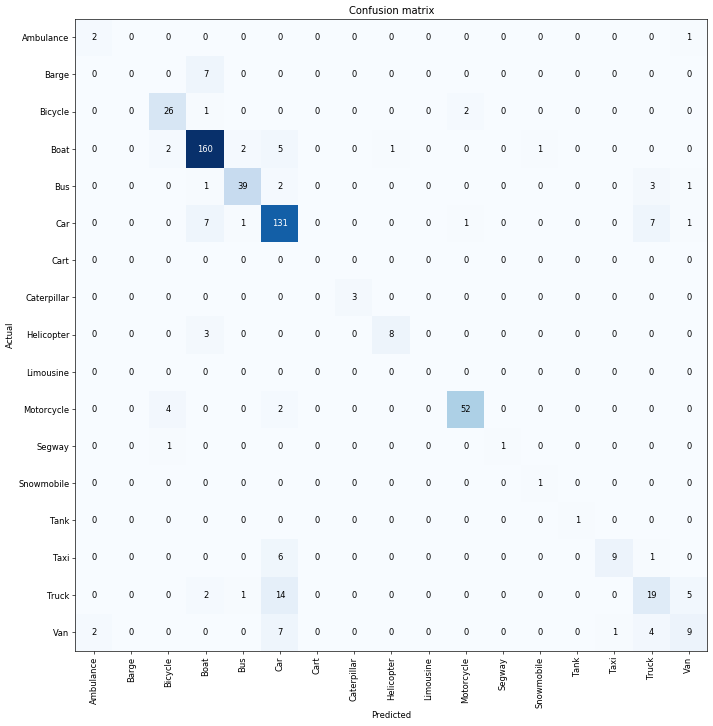

In [0]:
learn.save('stage-1-resnet-18-82-perct')

# **Make Prediction and submit**

In [0]:
DatasetType.Test

<DatasetType.Test: 3>

In [0]:
preds,y=learn.get_preds(ds_type=DatasetType.Test)
preds = np.argmax(preds, axis = 1)
preds_classes = [data.classes[i] for i in preds]


In [0]:
submission = pd.DataFrame({ 'file': os.listdir('/content/drive/My Drive/plant_seedlings/plant_seedling_extract/test'), 'species': preds_classes })
submission.to_csv('test_classification_results.csv', index=False)
